In [1]:
!pip install tensorflow==2.11.0

In [2]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
import torch
from transformers import AlbertTokenizer, TFAlbertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [3]:
MODEL_NAME = 'albert-base-v2'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 16
EPOCHS = 4

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_df = pd.read_csv("output.csv")

In [5]:
train_df.head()

,text_id,text,task_1,task_2,task_3
0,hasoc_en_1,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT,NONE,NONE
1,hasoc_en_2,@politico No. We should remember very clearly ...,HOF,HATE,TIN
2,hasoc_en_3,@cricketworldcup Guess who would be the winner...,NOT,NONE,NONE
3,hasoc_en_4,Corbyn is too politically intellectual for #Bo...,NOT,NONE,NONE
4,hasoc_en_5,All the best to #TeamIndia for another swimmin...,NOT,NONE,NONE


In [6]:
train_df['target']=train_df['task_1'].apply(lambda x:1 if x=='HOF' else 0)

In [7]:
train_df.head()

,text_id,text,task_1,task_2,task_3,target
0,hasoc_en_1,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT,NONE,NONE,0
1,hasoc_en_2,@politico No. We should remember very clearly ...,HOF,HATE,TIN,1
2,hasoc_en_3,@cricketworldcup Guess who would be the winner...,NOT,NONE,NONE,0
3,hasoc_en_4,Corbyn is too politically intellectual for #Bo...,NOT,NONE,NONE,0
4,hasoc_en_5,All the best to #TeamIndia for another swimmin...,NOT,NONE,NONE,0


In [8]:
import re
import string
def clean_text(text):
    # to lower case
    text = text.lower()
    # remove links
    text = re.sub('https:\/\/\S+', '', text)
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # remove next line
    text = re.sub(r'[^ \w\.]', '', text)
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)

    return text
# Create a new column called "Text" for collecting clean text
train_df['Text'] = train_df.text.apply(lambda x: clean_text(x))

In [9]:
train_df.head()

,text_id,text,task_1,task_2,task_3,target,Text
0,hasoc_en_1,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT,NONE,NONE,0,dhonikeepstheglove watch sports minister kire...
1,hasoc_en_2,@politico No. We should remember very clearly ...,HOF,HATE,TIN,1,politico no we should remember very clearly th...
2,hasoc_en_3,@cricketworldcup Guess who would be the winner...,NOT,NONE,NONE,0,cricketworldcup guess who would be the winner ...
3,hasoc_en_4,Corbyn is too politically intellectual for #Bo...,NOT,NONE,NONE,0,corbyn is too politically intellectual for bor...
4,hasoc_en_5,All the best to #TeamIndia for another swimmin...,NOT,NONE,NONE,0,all the best to teamindia for another swimming...


In [10]:
X_data = train_df[['Text']].to_numpy().reshape(-1)
y_data = train_df[['target']].to_numpy().reshape(-1)

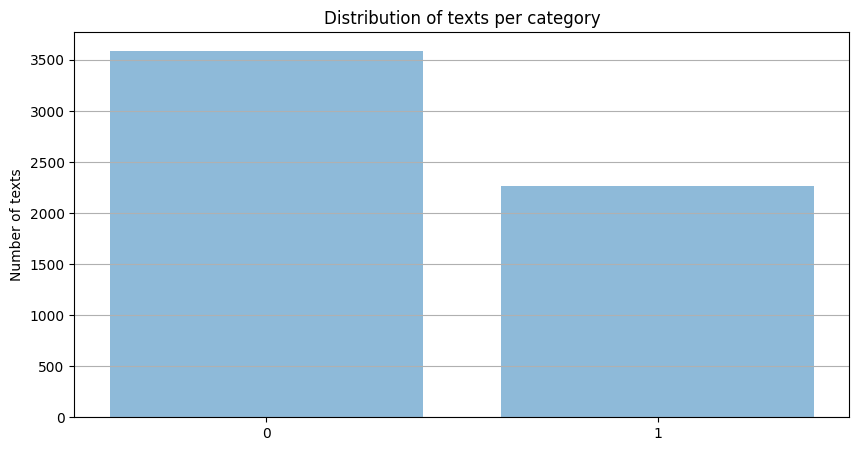

Counter({0: 3591, 1: 2261})


In [11]:
categories = train_df[['target']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [12]:
def calculate_stats(train_df, split_char=' '):
    categories = train_df['target'].unique()

    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in train_df.iterrows():
        text = row['Text']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)

        category = row['target']

        all_lengths.append(l)
        per_category['lengths'][category].append(l)

    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])

    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }

    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = train_df['target'].unique()
    n_rows = math.ceil(len(categories) / n_cols)

    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')

    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)

        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [13]:
df_stats = calculate_stats(train_df)
df_stats['per_category']

,lengths,mean,stdev
0,"[35, 21, 11, 16, 19, 7, 25, 35, 38, 22, 33, 17...",22.260373,11.927912
1,"[15, 17, 14, 14, 11, 37, 26, 31, 24, 5, 12, 13...",24.091552,12.450398


In [14]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = train_df['target'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 5852
Number of categories: 2
Done!


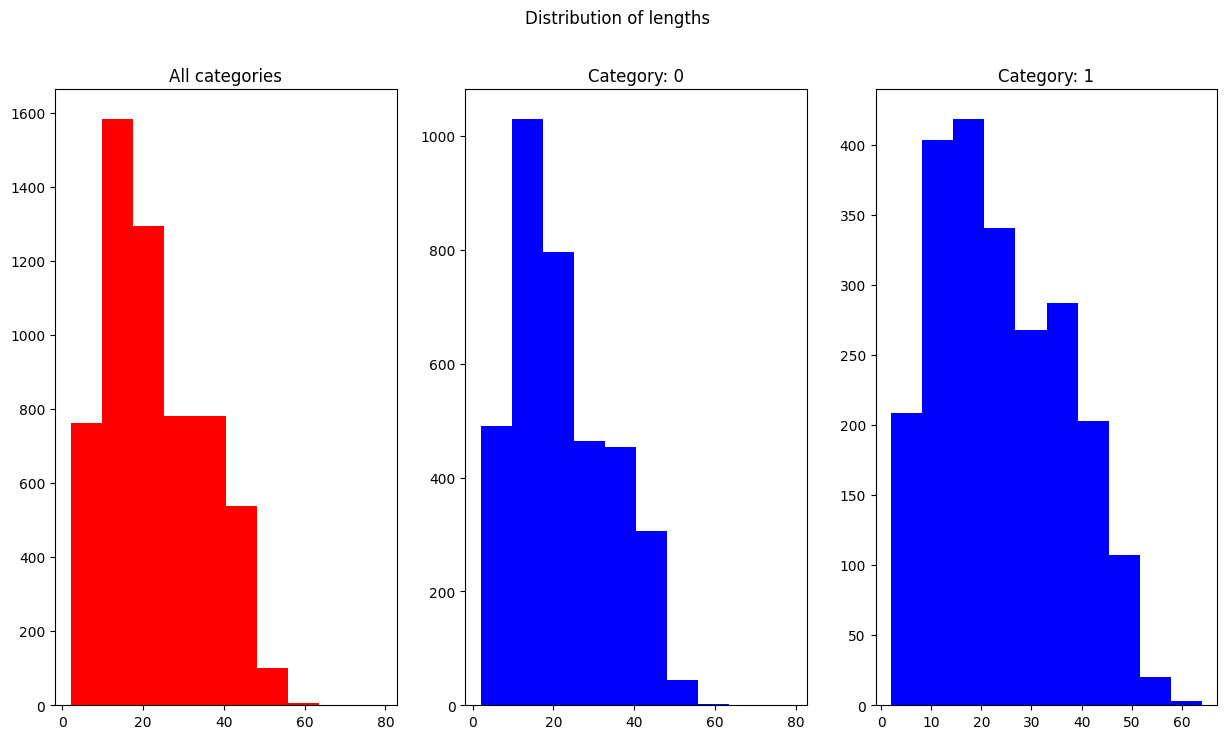

In [15]:
display_lengths_histograms(df_stats)

In [16]:
def albert_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)

        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])

        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN

        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')

        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777)

In [18]:
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

In [19]:
X_train = albert_encode(X_train, tokenizer)
X_test = albert_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [20]:
 strategy = tf.distribute.get_strategy()

In [21]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import albert model from HuggingFace
        albert_model = TFAlbertForSequenceClassification.from_pretrained('albert-base-v2')
        x = albert_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position

        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='binary_crossentropy',
            metrics=['accuracy'])

        return model

In [22]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_albert_for_sequence_classif  TFSequenceClassifie  11685122   ['input_word_ids[0][0]',         
 ication (TFAlbertForSequenceCl  rOutput(loss=None,               'input_mask[0][0]',         

In [ ]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/4
256/256 [==============================] - 12480s 49s/step - loss: 0.6719 - accuracy: 0.6108 - val_loss: 0.6766 - val_accuracy: 0.6122
Epoch 2/4
255/256 [============================>.] - ETA: 42s - loss: 0.6707 - accuracy: 0.6137 